# Neural Net from scratch

Go here for more info: https://github.com/DataScienceHamburg/PyTorchUltimateMaterial

## Creating the data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("data/heart.csv")
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
X = df.drop(columns=["output"])
y = df["output"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = StandardScaler()

# scale the data according to training data, and set mean and standard deviation for train data
# scaler.fit(X) : fits data according to dataset (calculates mean and standard deviation)
# scaler.transform(X) : transforms dataset according to its previously set parameters (mean and standard deviation)
X_train = scaler.fit_transform(X_train)

# scale according to training data, do not fit scaler to test data since we want to avoid bias.  
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Creating the class 

In [31]:
class NeuralNet:
    def __init__(self, X: np.ndarray, y: np.ndarray, alpha = 0.1):
        self.X = X.T
        self.y = y
        self.alpha = alpha

        input_layer_size = self.X.shape[0]
        
        # layer sizes
        self.n = [self.X.shape[0], 4, 1]

        # two layers
        self.L = 2 

        # 1. create weights
        # size should be n[l] x n[L-1]
        W1 = np.random.randn(self.n[1], self.n[0]) * 0.1 
        W2 = np.random.randn(self.n[2], self.n[1]) * 0.1
        self.W = {
            "1": W1,
            "2": W2
        }

        # 2. create bias, initialize to 0
        # size should be n[l] x 1 for column vector
        b1 = np.random.randn(self.n[1], 1)
        b2 = np.random.randn(self.n[2], 1)
        self.b = {
            "1": b1,
            "2": b2
        }

        # 3. create gradient cache
        self.cache = {
            "A1": None,
            "Z2": None,
        }

    def output_shape(self):
        print(f"Weights for layer 1 shape: {self.W['1'].shape}")
        print(f"Weights for layer 2 shape: {self.W['2'].shape}")
        
    @staticmethod
    def g(arr) -> np.ndarray:
        return 1 / (1 + np.exp(-arr))

    @staticmethod
    def gprime(y_hat) -> np.ndarray:
        return y_hat * (1 - y_hat)

    # vectorized implementation of feed forward
    def forward(self, X):
        m = X.shape[1]
        Z1 = self.W['1'] @ X + self.b['1']
        assert Z1.shape == (self.n[1], m)
        
        A1 = NeuralNet.g(Z1)
        self.cache["A1"] = A1
        
        Z2 = self.W['2'] @ A1 + self.b['2']
        self.cache["Z2"] = Z2
        assert Z2.shape == (self.n[2], m)
        
        A2 = NeuralNet.g(Z2)
        
        y_hat = A2
        return y_hat

    # using mean squared error as loss
    @staticmethod
    def loss(y_hat, y):
        return (y_hat.reshape(-1) - y.reshape(-1)) ** 2

    @staticmethod
    def cost(y_hat, y):
        m = y_hat.reshape(-1).shape[0]
        return np.sum(NeuralNet.loss(y_hat, y)) / m
        

    # vectorized implementation of feed forward
    def backward(self, y_hat, y):
        m = y_hat.reshape(-1).shape[0]

        """
        Layer 2 calculations

        
        """
        A2 = y_hat.reshape(1 , -1)
        pred = y.reshape(1 , -1)


        # 1. calculate dCdZ2, which lets you get dCdW2, dCdb1, and dCdA1 for next propagation
        
        dCdA2 = (1 / m)  * 2 * (A2 - pred)
        assert dCdA2.shape == (1, m), "something went wrong"

        dA2dZ2 = A2 * (1 - A2)
        assert dA2dZ2.shape == ( self.n[2] ,m) , f"shape is {dA2dZ2.shape}"

        dC_dZ2 = (dCdA2 * dA2dZ2)
        assert dC_dZ2.shape == (self.n[2] , m), f"shape mismatch {dC_dZ2.shape}"
        
        # 2. calculate dCdW2
        
        dZ2W2 = self.cache["A1"]
        assert dC_dZ2.shape == (self.n[2], m), f"shape mismatch {dC_dZ2.shape}"
        
        gradW2 = dC_dZ2 @ dZ2W2.T
        assert gradW2.shape == self.W['2'].shape

        # 3. calculate dbdW2
        
        gradb2 = np.sum( dC_dZ2, axis=1 ).reshape(self.n[2], 1)
        assert gradb2.shape == (self.n[2], 1)


        """
        Layer 1 calculations

        
        """

        # 1. with dC/dZ2 stored, calculate dC/dZ1 = dC/dZ2 * dZ2/dA1 * dA1/dZ1
        
        dZ2_dA1 = self.W['2']

        A1 = self.cache["A1"]
        dA1_dZ1 = A1 * (1 - A1)
        assert dA1_dZ1.shape == (self.n[1] , m), f"shape mismatch {dA1_dZ1.shape}"


        dC_dZ1 = (self.W['2'].T @ dC_dZ2) * dA1_dZ1
        assert dC_dZ1.shape == (self.n[1] , m), f"shape mismatch {dC_dZ1.shape}"

        # 2. calculate dC/dW1 = dC/dZ1 * dZ1/dW1
        
        dZ1_dW1 = self.X
        gradW1 = dC_dZ1 @ dZ1_dW1.T
        assert gradW1.shape == self.W['1'].shape, f"gradient shape mismatch"
        
        # 3. calculate dC/db1 = dC/dZ1 * dZ1/db1
        
        gradb1 = np.sum(  dC_dZ1, axis=1 ).reshape(self.n[1], 1)

        return {
            "gradW2" : gradW2,
            "gradb2" : gradb2,
            "gradW1" : gradW1,
            "gradb1" : gradb1
        }

    def train(self, epochs = 1000):
        costs = []
        for e in range(epochs):
            # 1. hypothesis
            y_hat = self.forward(self.X)

            # 2. calculate cost
            cost = NeuralNet.cost(y_hat, self.y)
            costs.append(cost)

            # 3. backprop
            grads = self.backward(y_hat, self.y)

            # 4. update parameters
            self.W['2'] += -self.alpha * grads['gradW2']
            self.W['1'] += -self.alpha * grads['gradW1']
            
            self.b['2'] += -self.alpha * grads['gradb2']
            self.b['1'] += -self.alpha * grads['gradb1']

            if e % 20 == 0:
                print(f"epoch {e}: cost is {cost}")

        return costs

In [32]:
net = NeuralNet(
    X=X_train,
    y=y_train
)
costs = net.train(10000)

epoch 0: cost is 0.24798824835527614
epoch 20: cost is 0.24706891532317807
epoch 40: cost is 0.24642399055839986
epoch 60: cost is 0.24584428507390044
epoch 80: cost is 0.24523923010584694
epoch 100: cost is 0.2445617742455527
epoch 120: cost is 0.24377911186046994
epoch 140: cost is 0.24286156293121022
epoch 160: cost is 0.24177835564554961
epoch 180: cost is 0.24049606668927756
epoch 200: cost is 0.23897821639907085
epoch 220: cost is 0.23718555667026198
epoch 240: cost is 0.23507698189118975
epoch 260: cost is 0.23261113411419013
epoch 280: cost is 0.22974880003943157
epoch 300: cost is 0.2264561480164111
epoch 320: cost is 0.2227087343511064
epoch 340: cost is 0.21849602204622073
epoch 360: cost is 0.2138259149167097
epoch 380: cost is 0.20872855071350352
epoch 400: cost is 0.20325838918034406
epoch 420: cost is 0.19749359687846108
epoch 440: cost is 0.19153202836355468
epoch 460: cost is 0.1854838283671463
epoch 480: cost is 0.17946169606209714
epoch 500: cost is 0.173570725583951

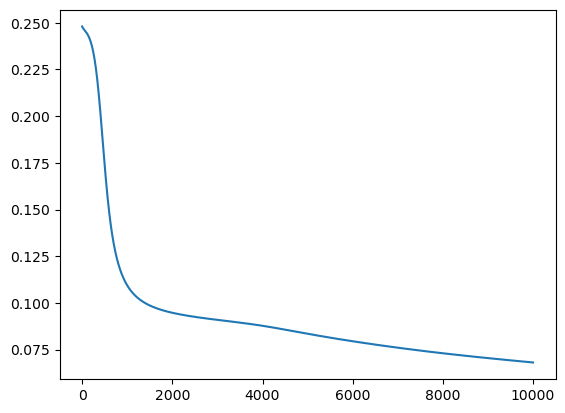

In [33]:
import matplotlib.pyplot as plt

plt.plot(costs)

In [34]:
def predict(net: NeuralNet, X, y):
    y_hat = net.forward(X)
    prediction = np.round(y_hat).astype(int).reshape(-1)
    m = y_hat.reshape(-1).shape[0]
    num_correct = np.where(prediction == y)[0].shape[0]
    print(f"got {num_correct}/{m} correct")
    
    predictionFrame = pd.DataFrame(
            data=np.hstack([prediction.reshape(m, -1), y_hat.reshape(m, -1), y.reshape(m, -1)]),
            columns=["predicted", "y_hat", "actual"]
      )
    return predictionFrame
    

In [35]:
predict(net, X_test.T, y_test) # expects X to be n x m matrix 

got 48/61 correct


,predicted,y_hat,actual
0,1.0,0.988272,1.0
1,0.0,0.038224,0.0
2,0.0,0.007500,0.0
3,0.0,0.006754,0.0
4,1.0,0.977814,1.0
...,...,...,...
56,0.0,0.025418,1.0
57,1.0,0.976286,1.0
58,1.0,0.831196,0.0
59,0.0,0.326352,1.0
